In [1]:
import json
import glob
import os

import imgaug.augmentables as ia
import albumentations as A

from shapely import geometry
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
import numpy as np

import torchvision as tv

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch

import pytorch_lightning as pl

from effdet.east.model import EfficientDetDoesEAST
from effdet.east.losses import BalancedBCE

In [1]:
import neptune
project = neptune.init_project(project="israelcamp/TextDetection", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMTBjNDM4Ni0zODcwLTQyYTItYmI3MS1kZmUwMmNkNmJlZDUifQ==")

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/israelcamp/TextDetection/


In [4]:
project["general/brief"] = 'https://app.neptune.ai/israelcamp/TextDetection/'
project["general/data_analysis"].upload("data_analysis.ipynb")
project["dataset/v0.1"].track_files("s3://datasets/images")
project["dataset/latest"] = project["dataset/v0.1"].fetch()

FetchAttributeNotFoundException: 
[95m
----MetadataInconsistency----------------------------------------------------------------------
[0m
The field [96mdataset/v0.1[0m was not found.

Remember that in the asynchronous (default) connection mode, data is synchronized
with the Neptune servers in the background. The data may have not reached
the servers before it was fetched. Before fetching the data, you can force
wait for all the requests sent by invoking:

    [96mrun.wait()[0m

Remember that each use of [96mwait[0m introduces a delay in code execution.

You may also want to check the following docs page:
    - https://docs.neptune.ai/api/connection_modes

[92mNeed help?[0m-> https://docs.neptune.ai/getting_help.html


[neptune] [error  ] Unexpected error occurred in Neptune background thread: Killing Neptune asynchronous thread. All data is safe on disk and can be later synced manually using `neptune sync` command.


Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "/home/athenaai/anaconda3/envs/effDet/lib/python3.9/site-packages/neptune/common/backends/utils.py", line 79, in wrapper
    return func(*args, **kwargs)
  File "/home/athenaai/anaconda3/envs/effDet/lib/python3.9/site-packages/neptune/internal/backends/hosted_neptune_backend.py", line 680, in _execute_operations
    result = self.leaderboard_client.api.executeOperations(**kwargs).response().result
  File "/home/athenaai/anaconda3/envs/effDet/lib/python3.9/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 113, in __call__
    self.handle_neptune_http_errors(e.response, exception=e)
  File "/home/athenaai/anaconda3/envs/effDet/lib/python3.9/site-packages/neptune/internal/backends/swagger_client_wrapper.py", line 106, in handle_neptune_http_errors
    raise exception
  File "/home/athenaai/anaconda3/envs/effDet/lib/python3.9/site-packages/neptune/internal/backends/swagger_client_w

In [2]:
image_folder = './datasets/train_task2_images/'
image_files = glob.glob('./datasets/train_task2_images/*.jpg')
with open('./datasets/train_task2_labels.json', 'rb') as f:
    image_labels = json.load(f)

In [3]:
len(image_files), len(image_labels)

(50029, 50029)

In [5]:
def get_image_and_mask_from_name_up():
    annotations = image_labels['annotations'][0]['name']
    image = Image.open(os.path.join(image_folder, image_labels['item']['name']))
    mask = Image.new('L', size=image.size, color=0)
    draw = ImageDraw.Draw(mask)
    for annot in annotations:
        # Assuming 'annot' here refers directly to the structure like 'polygon' dict you've provided
        # Extract points from the paths
        if 'polygon' in annot and 'paths' in annot['polygon']:
            for path in annot['polygon']['paths']:
                # Convert the list of dictionaries to a list of (x, y) tuples
                points = [(point['x'], point['y']) for point in path]
                draw.polygon(points, fill=255)

    # Convert image and mask to numpy arrays as required
    np_image = np.array(image, dtype='uint8')  # Assuming image_type is 'uint8'
    np_mask = (1 * (np.array(mask) != 0)).astype('uint8')  # Assuming mask_type is 'uint8'

    # Returning np_image and np_mask, which should now include your polygon
    return np_image, np_mask

In [41]:
np_image, np_mask = get_image_and_mask_from_name_up()

In [4]:
def get_image_and_mask_from_name(gt_name, image_type=np.uint8, mask_type=np.uint8):
    annotations = image_labels[gt_name]
    image = Image.open(os.path.join(image_folder, f'{gt_name}.jpg'))
    mask = Image.new('L', size=image.size, color=0)
    draw = ImageDraw.Draw(mask)
    for annot in annotations:
        draw.polygon(tuple(tuple(xy) for xy in annot['points']), fill=255)
    np_image = np.array(image, dtype=image_type)
    np_mask = (1 * (np.array(mask) != 0)).astype(mask_type)
    return np_image, np_mask

In [5]:
def view_image_and_mask(image, mask):
    ia_mask = ia.SegmentationMapsOnImage(mask, mask.shape)
    return Image.fromarray(ia_mask.draw_on_image(image.astype(np.uint8), alpha=0.5)[0])

In [9]:
np_image, np_mask = get_image_and_mask_from_name('gt_1_5')

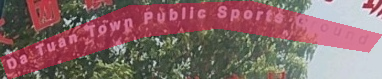

In [10]:
view_image_and_mask(np_image, np_mask)

# Dataset

In [11]:
class ArTDataset(Dataset):
    
    
    resize_tfms = A.Resize(768, 768)
    resize_mask_tfms = A.Resize(768//4, 768//4)
    
    train_tfms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Affine(scale=(0.9, 1.1), translate_percent=(-0.1, 0.1), rotate=(-10, 10), p=0.3),
    ])
    
    lambda_tfms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(lambda x: 2 * x -1) # for EffNet advprop
    ]) 
        
    def __init__(self, image_names:str, image_labels:dict, is_train=False):
        self.image_names = image_names
        self.image_labels = image_labels
        self.is_train = is_train
        
    def __len__(self,):
        return len(self.image_names)
        
    def __getitem__(self, idx):
        gt_name = self.image_names[idx]
        image_org, mask = get_image_and_mask_from_name(gt_name)
        
        # RESIZE
        transformed = self.resize_tfms(image=image_org, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        
        if self.is_train:
            transformed = self.train_tfms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # NORMALIZE
        image = self.lambda_tfms(image)
        
        
        # RESIZE MASK
        transformed = self.resize_mask_tfms(image=image_org, mask=mask)
        mask = transformed['mask']
        
        return image, mask

In [10]:
ds_debug = ArTDataset(['gt_0_2', 'gt_1_5'], image_labels, is_train=True)

In [24]:
img, mask = ds_debug[1]
# img = (img + 1.) / 2.
# view_image_and_mask(img.permute(1, 2, 0).numpy()*255, mask)

In [13]:
img.shape, mask.shape

(torch.Size([3, 768, 768]), (192, 192))

In [12]:
class ArTDataModule(pl.LightningDataModule):
    
    def __init__(self, image_labels, val_pct=0.1, train_bs=2, valid_bs=4):
        super().__init__()
        self.image_labels = image_labels
        self.image_names = sorted(list(image_labels.keys()))
        self.train_bs = train_bs
        self.valid_bs = valid_bs
        self.val_pct = val_pct
        
    def setup(self, stage):
        if stage == 'fit':
            train_size = round(len(self.image_names) * self.val_pct)
            self.train_dataset = ArTDataset(self.image_names[:train_size], image_labels)
            self.valid_dataset = ArTDataset(self.image_names[train_size:], image_labels)
        if stage == 'test':
            self.test_dataset = self.valid_dataset
            
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_bs, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.valid_bs)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.valid_bs)

In [13]:
def visualize_batch(img, mask):
    grid_image = tv.utils.make_grid(img, nrow=8)
    iam = ia.SegmentationMapsOnImage(mask.permute(1,2,0).numpy(), shape=mask.shape[1:])
    iam = iam.resize(768)
    mask = torch.tensor(iam.arr).permute(2, 0, 1)

    grid_mask = tv.utils.make_grid(mask.unsqueeze(1), nrow=8)

    plt.figure(figsize=(5,5))
    grid_image = (grid_image + 1)/2
    plt.imshow(grid_image.permute(1,2,0))
    plt.imshow(grid_mask.permute(1,2,0)*255, alpha=.5)

In [14]:
dm_kwargs = {
    'val_pct': 0.1,
    'train_bs': 2,
    'valid_bs': 4
}

In [15]:
data_module = ArTDataModule(image_labels, **dm_kwargs)

In [17]:
data_module.setup('fit')

In [18]:
img, mask = next(iter(data_module.train_dataloader()))

In [19]:
# Print shapes and basic stats
print("Image batch shape:", img.shape)
print("Mask batch shape:", mask.shape)
print("Batch image mean:", img.mean().item())
print("Batch image std:", img.std().item())

Image batch shape: torch.Size([2, 3, 768, 768])
Mask batch shape: torch.Size([2, 192, 192])
Batch image mean: -0.41349318623542786
Batch image std: 0.4950101375579834


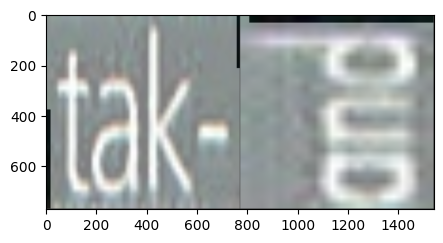

In [20]:
visualize_batch(img, mask)

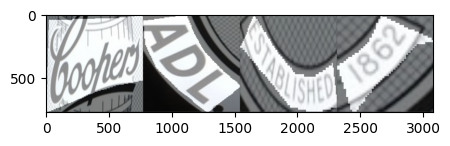

In [21]:
img, mask = next(iter(data_module.val_dataloader()))
visualize_batch(img, mask)

# Model

In [22]:
class DiceLoss(nn.Module):
    
    def forward(self, y_true, scores, eps=1e-8):
        # compute the actual dice score
        dims = (1, 2)
        intersection = torch.sum(scores * y_true, dims)
        cardinality = torch.sum(scores + y_true, dims)

        dice_score = 2. * intersection / (cardinality + eps)
        return torch.mean(-dice_score + 1.)

In [23]:
class EffDetSegmentationPart(EfficientDetDoesEAST):
    
    def forward(self, x):
        _, _, height, width = x.shape
        feats = self.backbone(x)

        scores = self.scores(feats)
        scores = torch.sigmoid(scores)

        score_map = scores[:, 0] # take only the segmentation scores
        return score_map

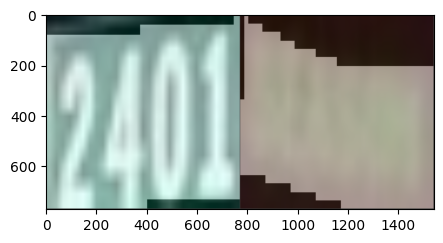

In [24]:
img, mask = next(iter(data_module.train_dataloader()))
visualize_batch(img, mask)

In [25]:
model = EffDetSegmentationPart(advprop=True, compound_coef=4)

Loaded pretrained weights for efficientnet-b4


In [26]:
model.eval()
with torch.no_grad():
    scores = model(img)

In [27]:
scores.shape, mask.shape

(torch.Size([2, 192, 192]), torch.Size([2, 192, 192]))

In [28]:
loss_fn = DiceLoss()

In [29]:
mask.shape, scores.shape

(torch.Size([2, 192, 192]), torch.Size([2, 192, 192]))

In [30]:
loss = loss_fn(mask, scores)

In [31]:
loss

tensor(0.4050)

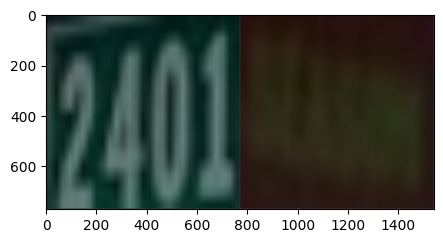

In [32]:
pred = (1*(scores > 0.5)).type(torch.uint8)
visualize_batch(img, pred)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [34]:
model.backbone.backbone_net.requires_grad_(False)

EfficientNet(
  (model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [37]:
len(data_module.train_dataloader())

2502

In [85]:
for batch in data_module.train_dataloader():  # Loop over all batches in the training DataLoader
    images, masks = batch  # Assuming your DataLoader returns images and their corresponding masks
    images, masks = images.cuda(), masks.cuda()  #

    print("Images: ",images)
    print("Masks: ",masks)
    break


Images:  tensor([[[[ 0.6784,  0.6784,  0.6784,  ...,  0.6863,  0.6863,  0.6863],
          [ 0.6784,  0.6784,  0.6784,  ...,  0.6863,  0.6863,  0.6863],
          [ 0.6784,  0.6784,  0.6784,  ...,  0.6863,  0.6863,  0.6863],
          ...,
          [ 0.6863,  0.6863,  0.6863,  ...,  0.6235,  0.6235,  0.6235],
          [ 0.6863,  0.6863,  0.6863,  ...,  0.6235,  0.6235,  0.6235],
          [ 0.6863,  0.6863,  0.6863,  ...,  0.6235,  0.6235,  0.6235]],

         [[ 0.6314,  0.6314,  0.6314,  ...,  0.7176,  0.7176,  0.7176],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.7176,  0.7176,  0.7176],
          [ 0.6314,  0.6314,  0.6314,  ...,  0.7176,  0.7176,  0.7176],
          ...,
          [ 0.6471,  0.6471,  0.6471,  ...,  0.6941,  0.6941,  0.6941],
          [ 0.6471,  0.6471,  0.6471,  ...,  0.6941,  0.6941,  0.6941],
          [ 0.6471,  0.6471,  0.6471,  ...,  0.6941,  0.6941,  0.6941]],

         [[ 0.6314,  0.6314,  0.6314,  ...,  0.7255,  0.7255,  0.7255],
          [ 0.6314,  

In [38]:
# Move the model to GPU
model = model.cuda()

num_epochs = 4  # Number of epochs to train for

for epoch in range(num_epochs):
    print(f'Epoch No: {epoch} started.....')
    model.train()
    model.backbone.freeze_bn()  # freeze BN
    
    epoch_loss = 0.0
    for batch in data_module.train_dataloader():  # Loop over all batches in the training DataLoader
        images, masks = batch  # Assuming your DataLoader returns images and their corresponding masks
        images, masks = images.cuda(), masks.cuda()  # Move data to GPU
        
        model.zero_grad()
        
        scores = model(images)  # Pass the batch of images through the model
        loss = loss_fn(masks, scores)  # Calculate loss
        
        if loss.isnan().item():
            print("NaN loss encountered. Stopping training.")
            break  # Exit if loss is NaN
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()  # Accumulate loss
        print(f'Current batch epoch loss: ',loss.item() / len(images))
    avg_loss = epoch_loss / len(data_module.train_dataloader())  # Calculate average loss for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch No: 0 started.....
Current batch epoch loss:  0.21316251158714294
Current batch epoch loss:  0.2538880705833435
Current batch epoch loss:  0.2065218985080719
Current batch epoch loss:  0.24103248119354248
Current batch epoch loss:  0.18484441936016083
Current batch epoch loss:  0.2179778665304184
Current batch epoch loss:  0.21022652089595795
Current batch epoch loss:  0.18952225148677826
Current batch epoch loss:  0.24981683492660522
Current batch epoch loss:  0.24086004495620728
Current batch epoch loss:  0.2259463667869568
Current batch epoch loss:  0.19107499718666077
Current batch epoch loss:  0.21266664564609528
Current batch epoch loss:  0.2405296266078949
Current batch epoch loss:  0.17555706202983856
Current batch epoch loss:  0.20359428226947784
Current batch epoch loss:  0.2007916420698166
Current batch epoch loss:  0.20553265511989594
Current batch epoch loss:  0.22062762081623077
Current batch epoch loss:  0.19963838160037994
Current batch epoch loss:  0.154462277889

In [45]:
for _ in range(100):
    model.train()
    model.backbone.freeze_bn() # freeze BN
    
    model.zero_grad()
    
    scores = model(data_module.cuda())
    loss = loss_fn(mask.cuda(), scores)
    
    
    if loss.isnan().item():
        model.zero_grad()
        break
    
    loss.backward()
    optimizer.step()
    
    print(loss)

tensor(0.3754, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3739, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3724, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3709, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3694, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3661, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3643, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3624, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3603, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3443, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3232, device='cuda:0',

In [46]:
loss

tensor(0.1644, device='cuda:0', grad_fn=<MeanBackward0>)

In [47]:
scores

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [26]:
img = Image.open('datasets/train_task2_images/gt_0_0.jpg')

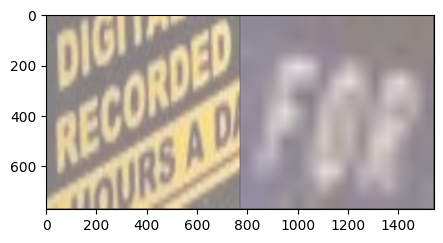

In [29]:
model.eval().cpu()
with torch.no_grad():
    scores = model(img)
pred = (1*(scores > 0.5)).type(torch.uint8)
visualize_batch(img, pred)